In [1]:
# --- Install latest libraries (uncomment if needed) ---
#%pip install -U torch torchvision torchaudio
#%pip install -U fastai transformers timm torchmetrics datasets
#%pip install -U accelerate

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import numpy as np
import cv2
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 
                     'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: mps
PyTorch version: 2.8.0


In [3]:
#Import your dataset
file_path_annotations = '/Users/yuen@backbase.com/Downloads/School/Emorec/emo-rec/scripts/npy_images/npy_dataset.csv'
file_path_images1 = '/Users/yuen@backbase.com/Downloads/School/Emorec/emo-rec/scripts/npy_images/Run_1'
file_path_images2 = '/Users/yuen@backbase.com/Downloads/School/Emorec/emo-rec/scripts/npy_images/Run_2'

In [4]:
import glob 

def collect_images_fastest(directories):
    """Fastest approach using glob patterns"""
    image_files = []
    patterns = ['**/*.jpg', '**/*.npy']

    for directory in directories:
        if Path(directory).exists():
            for pattern in patterns:
                image_files.extend(glob.glob(str(Path(directory) / pattern), recursive=True))

    return pd.DataFrame({'image_path': image_files})

# Collect image paths
directories = [file_path_images1, file_path_images2]
image_files_df = collect_images_fastest(directories)

#Normalise image_paths 
image_files_df['normalized_image_path'] = image_files_df['image_path'].str.replace('/Users/yuen@backbase.com/Downloads/School/Emorec/emo-rec/scripts/npy_images', '', regex=False).str.lstrip('/').str.rsplit('.', n=1).str[0]

display(image_files_df.head())
print(f"\nTotal number of image files found: {len(image_files_df)}")

,image_path,normalized_image_path
0,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Loving seniors rally/IMG_0364-3-1024x683
1,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Happy seniors conference/seniors-cafe
2,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Angry people work/12_Angry_Men-1200x675
3,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Confident adults festival/purim
4,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Kind youth birthday/1special-events-birt...



Total number of image files found: 18724


In [5]:
annotations_df = pd.read_csv(file_path_annotations)
annotations_df['normalized_image_path'] = annotations_df['image_path'].str.replace('\\', '/', regex=False).str.lstrip('/').str.rsplit('.', n=1).str[0]

# Drop the unwanted columns
columns_to_drop = ['index','full_img_path', 'image_path', 'npy_filename', 'original_filename', '']
existing_columns_to_drop = [col for col in columns_to_drop if col in annotations_df.columns]
annotations_df = annotations_df.drop(columns=existing_columns_to_drop)

print("\nAnnotations Data:")
display(annotations_df.head())
print(f"\nTotal number of annotations found: {len(annotations_df)}")


Annotations Data:


,user,tags,age,valence,arousal,emotion,dec_factors,ambiguity,datetime,npy_path,npy_folder,normalized_image_path
0,5fd85707af5bd719a5e20419,"Copyright,Watermark","Young Adults,Adults",0.0,5.0,Ecstasy,"Neutral,Staging",2.0,2023-11-10 14:51:41.404331,./npy_images/Run_1/Loving seniors rally/IMG_03...,Run_1/Loving seniors rally,Run_1/Loving seniors rally/IMG_0364-3-1024x683
1,6137b173cb7545edf5e05406,Undefined,Seniors,2.0,1.0,Serenity,Context,1.0,2023-09-01 00:00:00.000000,./npy_images/Run_1/Happy seniors conference/se...,Run_1/Happy seniors conference,Run_1/Happy seniors conference/seniors-cafe
2,5edb6c7b9c98557dc4530ce1,Undefined,Adults,-2.0,4.0,Loathing,"BodyLanguage,Context,FacialExpression",2.0,2023-09-20 20:10:01.384065,./npy_images/Run_1/Angry people work/12_Angry_...,Run_1/Angry people work,Run_1/Angry people work/12_Angry_Men-1200x675
3,60b10621950e9a293c1e4f02,Undefined,"Children,Youth",2.0,4.0,Joy,"BodyLanguage,FacialExpression",1.0,2023-11-15 11:17:28.833643,./npy_images/Run_1/Confident adults festival/p...,Run_1/Confident adults festival,Run_1/Confident adults festival/purim
4,60eae4b46c198651395d4706,Undefined,Children,2.0,5.0,Interest,"BodyLanguage,FacialExpression",1.0,2023-09-01 00:00:00.000000,./npy_images/Run_1/Kind youth birthday/1specia...,Run_1/Kind youth birthday,Run_1/Kind youth birthday/1special-events-birt...



Total number of annotations found: 18725


In [ ]:
if 'normalized_image_path' in image_files_df.columns and 'normalized_image_path' in annotations_df.columns:
  merged_df = pd.merge(image_files_df, annotations_df, on='normalized_image_path', how='left')

valence_col = 'valence'
arousal_col = 'arousal'

# Scale values to -1 to 1 if columns exist
if valence_col in merged_df.columns and arousal_col in merged_df.columns:
    print(f"Original valence range: {merged_df[valence_col].min():.3f} to {merged_df[valence_col].max():.3f}")
    print(f"Original arousal range: {merged_df[arousal_col].min():.3f} to {merged_df[arousal_col].max():.3f}")

    # Scale to -1 to 1
    scaler_valence = MinMaxScaler(feature_range=(-1, 1))
    scaler_arousal = MinMaxScaler(feature_range=(-1, 1))

    merged_df['valence_scaled'] = scaler_valence.fit_transform(merged_df[[valence_col]])
    merged_df['arousal_scaled'] = scaler_arousal.fit_transform(merged_df[[arousal_col]])

    print(f"Scaled valence range: {merged_df['valence_scaled'].min():.3f} to {merged_df['valence_scaled'].max():.3f}")
    print(f"Scaled arousal range: {merged_df['arousal_scaled'].min():.3f} to {merged_df['arousal_scaled'].max():.3f}")

    # Save scalers for later use
    scalers = {'valence': scaler_valence, 'arousal': scaler_arousal}
  
display(merged_df.head())
print(f"\nTotal number of rows in the merged dataframe: {len(merged_df)}")
print(f"\nNumber of rows with missing valence/arousal: {merged_df['valence'].isnull().sum()}")

Original valence range: -3.000 to 3.000
Original arousal range: 0.000 to 6.000
Scaled valence range: -1.000 to 1.000
Scaled arousal range: -1.000 to 1.000


,image_path,normalized_image_path,user,tags,age,valence,arousal,emotion,dec_factors,ambiguity,datetime,npy_path,npy_folder,valence_scaled,arousal_scaled
0,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Loving seniors rally/IMG_0364-3-1024x683,5fd85707af5bd719a5e20419,"Copyright,Watermark","Young Adults,Adults",0.0,5.0,Ecstasy,"Neutral,Staging",2.0,2023-11-10 14:51:41.404331,./npy_images/Run_1/Loving seniors rally/IMG_03...,Run_1/Loving seniors rally,0.000000,0.666667
1,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Happy seniors conference/seniors-cafe,6137b173cb7545edf5e05406,Undefined,Seniors,2.0,1.0,Serenity,Context,1.0,2023-09-01 00:00:00.000000,./npy_images/Run_1/Happy seniors conference/se...,Run_1/Happy seniors conference,0.666667,-0.666667
2,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Angry people work/12_Angry_Men-1200x675,5edb6c7b9c98557dc4530ce1,Undefined,Adults,-2.0,4.0,Loathing,"BodyLanguage,Context,FacialExpression",2.0,2023-09-20 20:10:01.384065,./npy_images/Run_1/Angry people work/12_Angry_...,Run_1/Angry people work,-0.666667,0.333333
3,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Confident adults festival/purim,60b10621950e9a293c1e4f02,Undefined,"Children,Youth",2.0,4.0,Joy,"BodyLanguage,FacialExpression",1.0,2023-11-15 11:17:28.833643,./npy_images/Run_1/Confident adults festival/p...,Run_1/Confident adults festival,0.666667,0.333333
4,/Users/yuen@backbase.com/Downloads/School/Emor...,Run_1/Kind youth birthday/1special-events-birt...,60eae4b46c198651395d4706,Undefined,Children,2.0,5.0,Interest,"BodyLanguage,FacialExpression",1.0,2023-09-01 00:00:00.000000,./npy_images/Run_1/Kind youth birthday/1specia...,Run_1/Kind youth birthday,0.666667,0.666667



Total number of rows in the merged dataframe: 18724

Number of rows with missing valence/arousal: 0


# DATA SPLITTING

In [7]:
# Configuration
BINS_PER_AXIS = 10  # starting number of bins per axis; auto-decreases if sparse
RANDOM_STATE = 42

def _make_strata(df: pd.DataFrame, bins_per_axis: int) -> tuple[pd.Series, int]:
    """Compute 2D-binned strata labels for V/A with a sparsity fallback.

    Returns a tuple of (strata_labels, used_bins_per_axis). The function will
    decrease the number of bins until each stratum in `df` has at least 2
    samples, or fall back to a single bucket.
    """
    v = df["valence"].clip(-3, 3)
    a = df["arousal"].clip(0, 6)

    for b in range(bins_per_axis, 1, -1):
        v_bins = pd.cut(
            v, bins=np.linspace(-3, 3, b + 1), labels=False, include_lowest=True
        )
        a_bins = pd.cut(
            a, bins=np.linspace(0, 6, b + 1), labels=False, include_lowest=True
        )
        strata = (v_bins.astype(int) * b + a_bins.astype(int)).astype(int)
        counts = strata.value_counts()
        if (counts >= 2).all():
            return strata, b

    # Fallback: single bucket for all samples
    return pd.Series(0, index=df.index, dtype=int), 1

# Drop rows with missing valence or arousal
df_filtered = merged_df.dropna(subset=['valence', 'arousal']).copy()

# Create strata for splitting
strata, used_bins = _make_strata(df_filtered, BINS_PER_AXIS)
print(f"Using {used_bins} bins per axis for stratification.")

# Split data into training and remaining sets (e.g., 80% train, 20% remaining)
train_df, remaining_df = train_test_split(
    df_filtered,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=strata
)

# Create strata for the remaining set for the next split
remaining_strata, _ = _make_strata(remaining_df, used_bins)

# Split remaining set into validation and test sets (e.g., 10% validation, 10% test)
val_df, test_df = train_test_split(
    remaining_df,
    test_size=0.5, # Splits the remaining 20% into two halves
    random_state=RANDOM_STATE,
    stratify=remaining_strata
)

print(f"\nFinal set size: {len(df_filtered)}")
print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Using 10 bins per axis for stratification.

Final set size: 18724

Training set size: 14979
Validation set size: 1872
Test set size: 1873


In [8]:
# Add these checks before your loading loop
print(f"DataFrame shape: {train_df.shape}")
print(f"DataFrame length: {len(train_df)}")
print(f"DataFrame index range: {train_df.index.min()} to {train_df.index.max()}")

# Ensure X_train and y_train are defined
X_train = train_df['image_path'].values
y_train = train_df[['valence_scaled', 'arousal_scaled']].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train sample: {y_train[100]}")  # Should show [valence, arousal]


DataFrame shape: (14979, 15)
DataFrame length: 14979
DataFrame index range: 1 to 18723
X_train shape: (14979,)
y_train shape: (14979, 2)
y_train sample: [-0.66666667  0.33333333]


# DATA AUGMENTATION

# MODEL CONFIGS & DATA GENERATOR 

In [9]:
# Custom CNN Configuration
MODEL_NAME = "custom_cnn_va_regression"  # Custom model identifier
IMAGE_SIZE = 224  # Standard size for CNN (can be 128, 224, 256, etc.)
BATCH_SIZE = 32
NUM_WORKERS = 8
EPOCHS = 10

# Use only a fraction of the dataset for faster experiments
DATA_FRACTION = 1  # Only downsamples Training Data
SAMPLE_SEED = 2025

# CNN specific configs
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001

In [10]:
# New one
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]  # This should be [valence, arousal] - 2 values
        
        try:
            # Check if it's a numpy file
            if image_path.endswith('.npy'):
                # Load numpy array
                image = np.load(image_path)
                
                # Check if image was loaded successfully
                if image is None or image.size == 0:
                    print(f"Warning: Could not load numpy image {image_path}, using black image")
                    image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
                else:
                    # Handle different numpy array shapes
                    if len(image.shape) == 3:
                        # Already RGB format
                        if image.shape[2] == 3:
                            pass  # Good as is
                        elif image.shape[2] == 1:
                            # Grayscale, convert to RGB
                            image = np.repeat(image, 3, axis=2)
                    elif len(image.shape) == 2:
                        # Grayscale, convert to RGB
                        image = np.stack([image] * 3, axis=2)
                    
                    # Resize image to match the CNN input size
                    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                    
                    # Ensure values are in [0, 1] range
                    if image.max() > 1.0:
                        image = image.astype(np.float32) / 255.0
                    else:
                        image = image.astype(np.float32)
            else:
                # Regular image file
                image = cv2.imread(image_path)
                
                # Check if image was loaded successfully
                if image is None:
                    print(f"Warning: Could not load image {image_path}, using black image")
                    image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
                else:
                    # Convert BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Resize image to match the CNN input size
                    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                
                # Convert to tensor and normalize
                image = image.astype(np.float32) / 255.0
            
            # Convert to tensor format (CHW)
            image = torch.from_numpy(image).permute(2, 0, 1)  # HWC to CHW
            
            # Apply transforms if any
            if self.transform:
                image = self.transform(image)
            
            # Convert labels to float tensor for regression
            return image, torch.tensor(label, dtype=torch.float32)
            
        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            # Return a black image as fallback
            black_image = torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE), dtype=torch.float32)
            return black_image, torch.tensor(label, dtype=torch.float32)
        
# Extract image paths and labels for training and validation datasets
X_train = train_df['image_path'].values
y_train = train_df[['valence_scaled', 'arousal_scaled']].values
X_val = val_df['image_path'].values
y_val = val_df[['valence_scaled', 'arousal_scaled']].values

# Now recreate your datasets with the fixed class
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)


In [11]:
try:
    sample_image, sample_label = train_dataset[40]
    print(f"Sample image shape: {sample_image.shape}")
    print(f"Sample label shape: {sample_label.shape}")
    print(f"Sample label: {sample_label}")
except Exception as e:
    print(f"Error loading sample: {e}")

Sample image shape: torch.Size([3, 224, 224])
Sample label shape: torch.Size([2])
Sample label: tensor([ 1.0000, -0.6667])


# DEFFINE MODEL

In [12]:
# Define the CNN model in PyTorch
class EmotionCNN(nn.Module):
    def __init__(self, num_outputs=2):
        super().__init__()
        # Add batch normalization
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Add more conv layers
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Improved FC layers
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_outputs)
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

# Initialize the model, loss function, and optimizer
model = EmotionCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Display the model architecture
print(model)

EmotionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bia

# TRAINING

In [13]:
# Now run your training loop
epochs = EPOCHS
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)

history = {'train_loss': [], 'val_loss': []}

print("Starting training...")
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    print(f"Epoch {epoch+1}/{epochs}")
    print("Training:", end=" ")
    
    for i, (images, labels) in enumerate(train_loader):
        try:
            images = images.to(device)
            labels = labels.to(device)
            
            # DEBUGGING: Check shapes on first batch
            if i == 0 and epoch == 0:
                print(f"\nFirst batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # DEBUGGING: Check output shape
            if i == 0 and epoch == 0:
                print(f"Model outputs shape: {outputs.shape}")
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Show progress every 10 batches
            if (i + 1) % 10 == 0:
                print(f"[{i+1}/{len(train_loader)}]", end=" ")
                
        except Exception as e:
            print(f"\nError in training batch {i}: {e}")
            continue
    
    avg_train_loss = train_loss / train_batches if train_batches > 0 else 0
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_batches = 0
    print("\nValidation:", end=" ")
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            try:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_batches += 1
                
                # Show progress every 5 batches
                if (i + 1) % 5 == 0:
                    print(f"[{i+1}/{len(val_loader)}]", end=" ")
                    
            except Exception as e:
                print(f"\nError in validation batch {i}: {e}")
                continue
    
    avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
    
    # Store and display results
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    print(f"\nTrain Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print("-" * 50)

print("Model training completed!")


Starting training...
Epoch 1/10
Training: 
First batch - Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 2])
Model outputs shape: torch.Size([32, 2])
[10/468] [20/468] [30/468] [40/468] [50/468] [60/468] [70/468] [80/468] [90/468] [100/468] [110/468] [120/468] [130/468] [140/468] [150/468] [160/468] [170/468] [180/468] [190/468] [200/468] [210/468] [220/468] [230/468] [240/468] [250/468] [260/468] [270/468] [280/468] [290/468] [300/468] [310/468] [320/468] [330/468] [340/468] [350/468] [360/468] [370/468] [380/468] [390/468] [400/468] [410/468] [420/468] [430/468] [440/468] [450/468] [460/468] 
Validation: [5/58] [10/58] [15/58] [20/58] [25/58] [30/58] [35/58] [40/58] [45/58] [50/58] [55/58] 
Train Loss: 0.4153, Val Loss: 0.3213
--------------------------------------------------
Epoch 2/10
Training: [10/468] [20/468] [30/468] [40/468] [50/468] [60/468] [70/468] [80/468] [90/468] [100/468] [110/468] [120/468] [130/468] [140/468] [150/468] [160/468] [170/468] [

KeyboardInterrupt: 

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'emotion_model1.pth')

# Save model configuration
config = {
    'image_size': IMAGE_SIZE,  # Your image size (e.g., 224)
    'dropout_rate': DROPOUT_RATE,  # Your dropout rate
    'num_outputs': 2,  # valence, arousal
}
torch.save(config, 'model_config1.pth')

print("Model saved successfully!")
print(f"Model weights: emotion_model.pth")
print(f"Model config: model_config.pth")

Model saved successfully!
Model weights: emotion_model.pth
Model config: model_config.pth


Evaluating model performance...

TRAINING SET EVALUATION METRICS
Valence MAE:           0.5059
Arousal MAE:           0.4543
Average MAE:           0.4801
Valence Correlation:   0.2700
Arousal Correlation:   0.0545
Average Correlation:   0.1623
Test Loss (MSE):       0.3199
RMSE:                  0.5656

VALIDATION SET EVALUATION METRICS
Valence MAE:           0.4999
Arousal MAE:           0.4551
Average MAE:           0.4775
Valence Correlation:   0.3090
Arousal Correlation:   0.0509
Average Correlation:   0.1800
Test Loss (MSE):       0.3173
RMSE:                  0.5633

TEST SET EVALUATION METRICS
Valence MAE:           0.5036
Arousal MAE:           0.4528
Average MAE:           0.4782
Valence Correlation:   0.2978
Arousal Correlation:   0.0527
Average Correlation:   0.1752
Test Loss (MSE):       0.3178
RMSE:                  0.5639


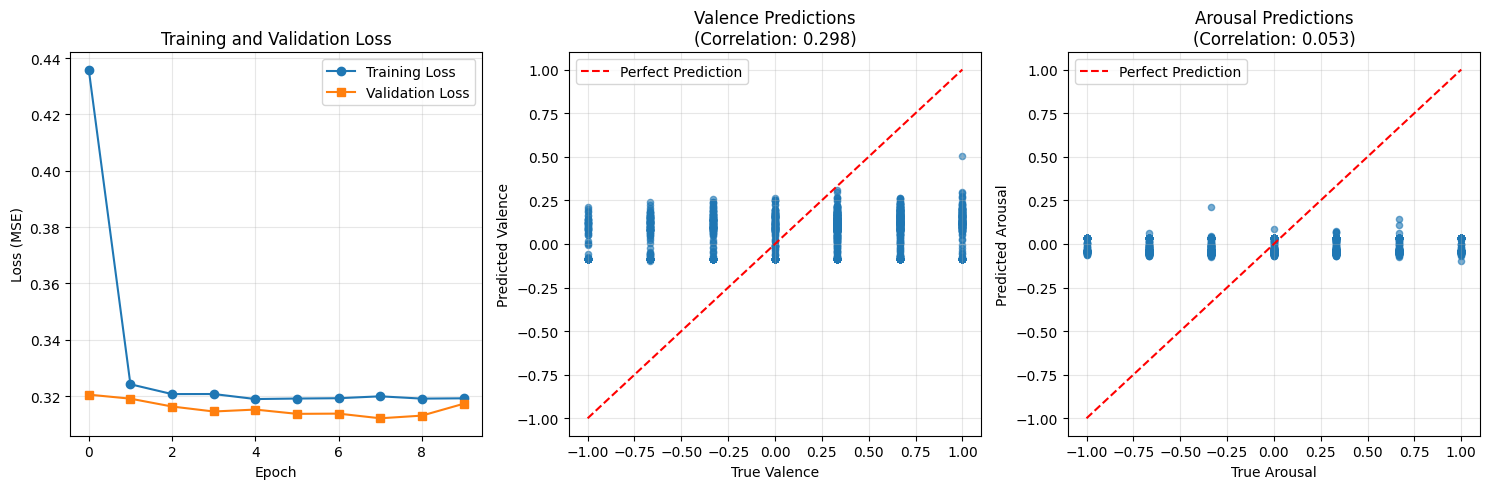

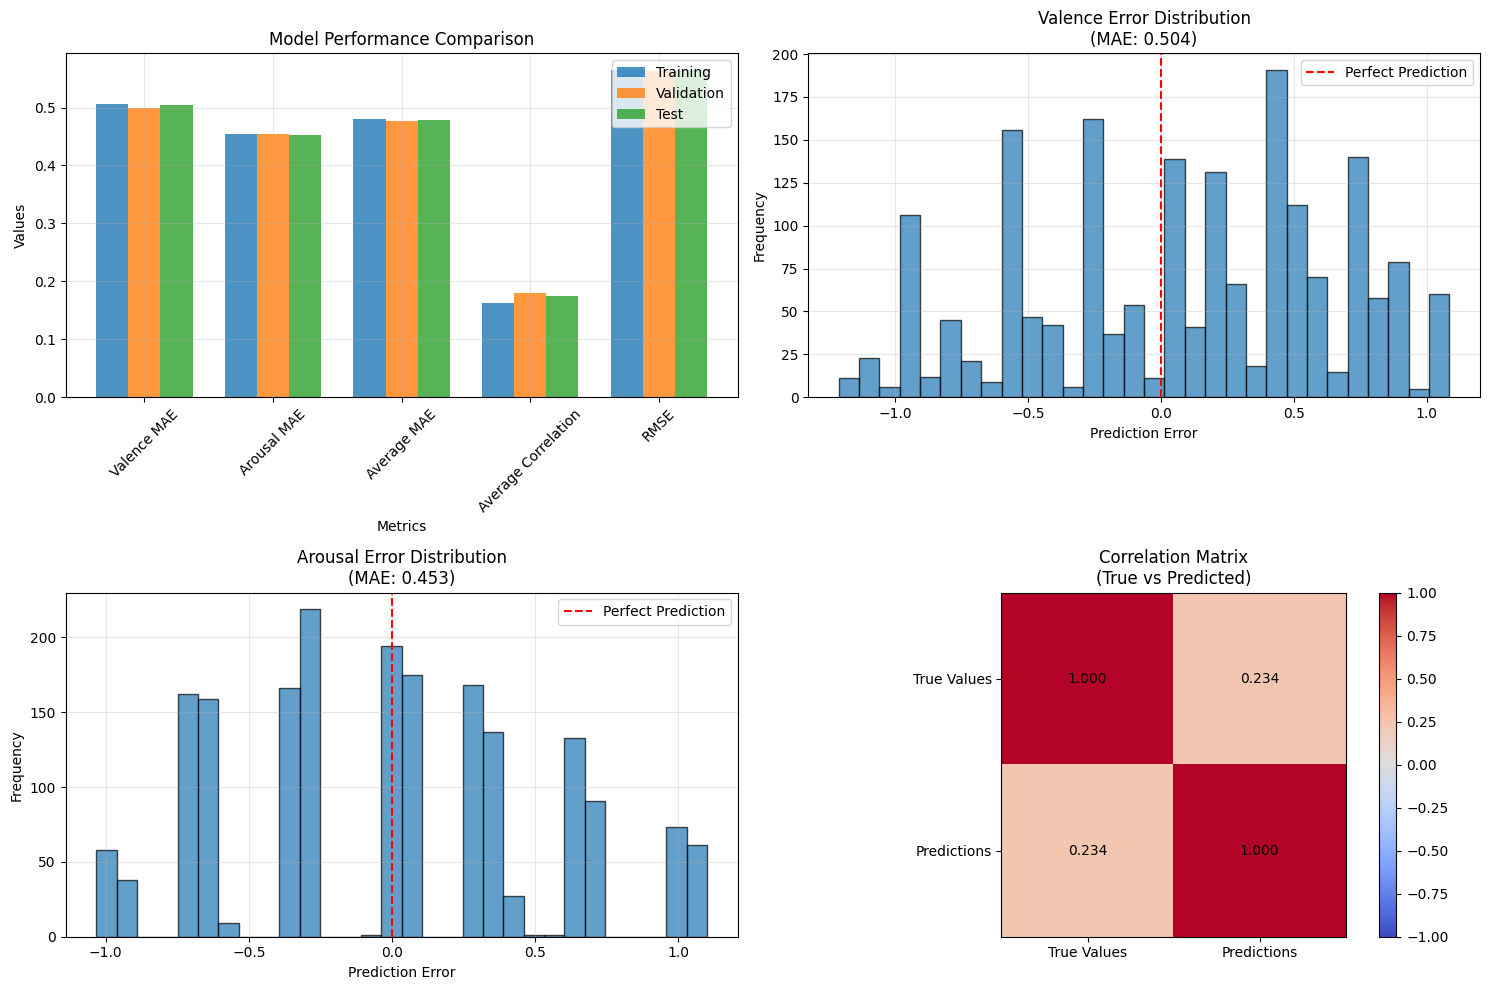


COMPREHENSIVE EVALUATION SUMMARY
              Metric Training Validation   Test
         Valence MAE   0.5059     0.4999 0.5036
         Arousal MAE   0.4543     0.4551 0.4528
         Average MAE   0.4801     0.4775 0.4782
Spearman Correlation   0.1623     0.1800 0.1752
                RMSE   0.5656     0.5633 0.5639
     Test Loss (MSE)   0.3199     0.3173 0.3178


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, data_loader, device, set_name=""):
    """Evaluate model and return all metrics"""
    model.eval()
    
    all_predictions = []
    all_labels = []
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            num_batches += 1
            
            # Store predictions and labels for metric calculation
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate all predictions and labels
    predictions = np.concatenate(all_predictions, axis=0)
    true_labels = np.concatenate(all_labels, axis=0)
    
    # Calculate metrics
    valence_pred = predictions[:, 0]
    arousal_pred = predictions[:, 1]
    valence_true = true_labels[:, 0]
    arousal_true = true_labels[:, 1]
    
    # MAE for valence and arousal
    valence_mae = mean_absolute_error(valence_true, valence_pred)
    arousal_mae = mean_absolute_error(arousal_true, arousal_pred)
    average_mae = (valence_mae + arousal_mae) / 2
    
    # Spearman correlation
    valence_corr, _ = spearmanr(valence_true, valence_pred)
    arousal_corr, _ = spearmanr(arousal_true, arousal_pred)
    average_corr = (valence_corr + arousal_corr) / 2
    
    # MSE and RMSE
    mse_loss = total_loss / num_batches
    valence_mse = mean_squared_error(valence_true, valence_pred)
    arousal_mse = mean_squared_error(arousal_true, arousal_pred)
    overall_mse = mean_squared_error(true_labels.flatten(), predictions.flatten())
    rmse = np.sqrt(overall_mse)
    
    metrics = {
        'valence_mae': valence_mae,
        'arousal_mae': arousal_mae,
        'average_mae': average_mae,
        'valence_corr': valence_corr,
        'arousal_corr': arousal_corr,
        'average_corr': average_corr,
        'mse_loss': mse_loss,
        'valence_mse': valence_mse,
        'arousal_mse': arousal_mse,
        'overall_mse': overall_mse,
        'rmse': rmse
    }
    
    return metrics, predictions, true_labels

def print_metrics(metrics, set_name):
    """Print metrics in a formatted way"""
    print(f"\n{'='*50}")
    print(f"{set_name.upper()} SET EVALUATION METRICS")
    print(f"{'='*50}")
    print(f"Valence MAE:           {metrics['valence_mae']:.4f}")
    print(f"Arousal MAE:           {metrics['arousal_mae']:.4f}")
    print(f"Average MAE:           {metrics['average_mae']:.4f}")
    print(f"Valence Correlation:   {metrics['valence_corr']:.4f}")
    print(f"Arousal Correlation:   {metrics['arousal_corr']:.4f}")
    print(f"Average Correlation:   {metrics['average_corr']:.4f}")
    print(f"Test Loss (MSE):       {metrics['mse_loss']:.4f}")
    print(f"RMSE:                  {metrics['rmse']:.4f}")
    print(f"{'='*50}")

# Create test dataset
X_test = test_df['image_path'].values
y_test = test_df[['valence_scaled', 'arousal_scaled']].values
test_dataset = EmotionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

print("Evaluating model performance...")

# Evaluate on all three sets
train_metrics, train_pred, train_true = evaluate_model(model, train_loader, device, "Training")
val_metrics, val_pred, val_true = evaluate_model(model, val_loader, device, "Validation")
test_metrics, test_pred, test_true = evaluate_model(model, test_loader, device, "Test")

# Print results
print_metrics(train_metrics, "Training")
print_metrics(val_metrics, "Validation")
print_metrics(test_metrics, "Test")

# Plot training history
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Valence predictions vs true values
plt.subplot(1, 3, 2)
plt.scatter(test_true[:, 0], test_pred[:, 0], alpha=0.6, s=20)
plt.plot([-1, 1], [-1, 1], 'r--', label='Perfect Prediction')
plt.xlabel('True Valence')
plt.ylabel('Predicted Valence')
plt.title(f'Valence Predictions\n(Correlation: {test_metrics["valence_corr"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Arousal predictions vs true values
plt.subplot(1, 3, 3)
plt.scatter(test_true[:, 1], test_pred[:, 1], alpha=0.6, s=20)
plt.plot([-1, 1], [-1, 1], 'r--', label='Perfect Prediction')
plt.xlabel('True Arousal')
plt.ylabel('Predicted Arousal')
plt.title(f'Arousal Predictions\n(Correlation: {test_metrics["arousal_corr"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional detailed plots
plt.figure(figsize=(15, 10))

# Plot 4: Metrics comparison across sets
metrics_names = ['Valence MAE', 'Arousal MAE', 'Average MAE', 'Average Correlation', 'RMSE']
train_vals = [train_metrics['valence_mae'], train_metrics['arousal_mae'], 
              train_metrics['average_mae'], train_metrics['average_corr'], train_metrics['rmse']]
val_vals = [val_metrics['valence_mae'], val_metrics['arousal_mae'], 
            val_metrics['average_mae'], val_metrics['average_corr'], val_metrics['rmse']]
test_vals = [test_metrics['valence_mae'], test_metrics['arousal_mae'], 
             test_metrics['average_mae'], test_metrics['average_corr'], test_metrics['rmse']]

x = np.arange(len(metrics_names))
width = 0.25

plt.subplot(2, 2, 1)
plt.bar(x - width, train_vals, width, label='Training', alpha=0.8)
plt.bar(x, val_vals, width, label='Validation', alpha=0.8)
plt.bar(x + width, test_vals, width, label='Test', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Error distribution for valence
plt.subplot(2, 2, 2)
valence_errors = test_true[:, 0] - test_pred[:, 0]
plt.hist(valence_errors, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title(f'Valence Error Distribution\n(MAE: {test_metrics["valence_mae"]:.3f})')
plt.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Error distribution for arousal
plt.subplot(2, 2, 3)
arousal_errors = test_true[:, 1] - test_pred[:, 1]
plt.hist(arousal_errors, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title(f'Arousal Error Distribution\n(MAE: {test_metrics["arousal_mae"]:.3f})')
plt.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 7: Correlation matrix heatmap
plt.subplot(2, 2, 4)
corr_matrix = np.corrcoef(np.column_stack([test_true.flatten(), test_pred.flatten()]).T)
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks([0, 1], ['True Values', 'Predictions'])
plt.yticks([0, 1], ['True Values', 'Predictions'])
plt.title('Correlation Matrix\n(True vs Predicted)')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{corr_matrix[i, j]:.3f}', ha='center', va='center')

plt.tight_layout()
plt.show()

# Summary table
summary_data = {
    'Metric': ['Valence MAE', 'Arousal MAE', 'Average MAE', 'Spearman Correlation', 'RMSE', 'Test Loss (MSE)'],
    'Training': [f"{train_metrics['valence_mae']:.4f}", f"{train_metrics['arousal_mae']:.4f}", 
                f"{train_metrics['average_mae']:.4f}", f"{train_metrics['average_corr']:.4f}",
                f"{train_metrics['rmse']:.4f}", f"{train_metrics['mse_loss']:.4f}"],
    'Validation': [f"{val_metrics['valence_mae']:.4f}", f"{val_metrics['arousal_mae']:.4f}", 
                  f"{val_metrics['average_mae']:.4f}", f"{val_metrics['average_corr']:.4f}",
                  f"{val_metrics['rmse']:.4f}", f"{val_metrics['mse_loss']:.4f}"],
    'Test': [f"{test_metrics['valence_mae']:.4f}", f"{test_metrics['arousal_mae']:.4f}", 
             f"{test_metrics['average_mae']:.4f}", f"{test_metrics['average_corr']:.4f}",
             f"{test_metrics['rmse']:.4f}", f"{test_metrics['mse_loss']:.4f}"]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

try:
    print("Using the trained model from the previous cell.")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Could not load weights. Please ensure the previous training cell ran successfully.")


# Select a sample of images and annotations from the validation set
print("\nMaking predictions on a sample of validation images...")
sample_size = 3
try:
    sample_images, sample_labels = next(iter(val_generator))
    sample_images = sample_images[:sample_size]
    sample_labels = sample_labels[:sample_size]

    sample_indices = val_generator.indices[val_generator.batch_size * 0 : val_generator.batch_size * 0 + sample_size]
    sample_df = val_generator.df.iloc[sample_indices]
    sample_filepaths = sample_df['full_img_path'].tolist()
    emotion_map_df = combined_df[['Arr_name', 'Peace', 'Affection', 'Esteem', 'Anticipation', 'Engagement', 'Confidence', 'Happiness', 'Pleasure', 'Excitement', 'Surprise', 'Sympathy', 'Doubt/Confusion', 'Disconnection', 'Fatigue', 'Embarrassment', 'Yearning', 'Disapproval', 'Aversion', 'Annoyance', 'Anger', 'Sensitivity', 'Sadness', 'Disquietment', 'Fear', 'Pain', 'Suffering']].copy()

    # Function to get emotion labels for a given image path
    def get_emotion_labels(full_path, emotion_df):
        arr_name = os.path.basename(full_path)
        # Find the row(s) matching the Arr_name
        matching_rows = emotion_df[emotion_df['Arr_name'] == arr_name]
        if not matching_rows.empty:
            # Return the emotion columns as a dictionary or list for the first match
            # Exclude 'Arr_name' itself
            emotions = matching_rows.iloc[0].drop('Arr_name').to_dict()
            # Filter for emotions with a score > 0 (assuming 0 means not present)
            present_emotions = {k: v for k, v in emotions.items() if v > 0}
            return present_emotions
        return {}


    # Make predictions on the sample images
    predictions = model.predict(sample_images)

    # Display images with actual and predicted scores and emotions
    print("\nDisplaying sample images with actual and predicted scores and emotions:")
    for i in range(sample_size):
        img_array = (sample_images[i] * 255).astype(np.uint8) # Denormalize for display
        img = Image.fromarray(img_array)

        actual_valence, actual_arousal = sample_labels[i]
        predicted_valence, predicted_arousal = predictions[i]

        # Get emotion labels for the current image
        emotion_labels = get_emotion_labels(sample_filepaths[i], emotion_map_df)


        print(f"Image {i+1}:")
        print(f"  Emotion Labels: {emotion_labels if emotion_labels else 'N/A'}")
        print(f"  Actual Valence: {actual_valence:.2f}, Actual Arousal: {actual_arousal:.2f}")
        print(f"  Predicted Valence: {predicted_valence:.2f}, Predicted Arousal: {predicted_arousal:.2f}")
        display(img)

except Exception as e:
    print(f"Error during prediction on sample images: {e}")

/Users/yuen@backbase.com/Downloads/School/Emorec/emo-rec/.venv/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/yuen@backbase.com/Downloads/School/Emorec/emo-rec/.venv/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/yuen@backbase.com/Downloads/School/Emorec/emo-rec/.venv/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older t

: 